# Experiments with the diversity condition violated

In this notebook I will perform the SimCLR experiments where the diversity condition was violated. Mathematically it essentially means that we will use the following distributions for sampling:

- $p(z) = \frac{1}{|\mathcal{Z}|}$ - Marginal distribution is simply a uniform distribution on a sphere
- $p(\tilde{z}|z) = \delta(u-u') \frac{e^{\kappa \tilde{z}^{T}z}}{\int_{W}e^{\kappa v^{T}v' dv}}$

Where the latent space can be decomposed into 2 components $z = (u,v)^{T}$ where $u \in R^{n}$, $v \in R^{m}$, and $m + n = d$ - the dimension of the latent space.

I will primarily work with hyper-spheres as my latent space, hence the condition $z^{2} = u^{2} + v^{2} = 1$ will be enforced.

Experiment with these data-generating processes:

- Identity ✅
- Linear Mapping (to 4D, 5D, 6D, 7D) ✅
- Spirals ✅
- Patches ✅
- Injective Neural Network as a data generating process ✅

For now fix one dimension (the first one):

Consider later:

- Fix multiple dimensions
- Fix dimensions randomly

In [4]:
%load_ext autoreload
%autoreload 2
    
import torch
from torch import nn
from torch import functional
from simclr.simclr import SimCLR
from encoders import get_mlp
import matplotlib.pyplot as plt
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 2000
kappa = tau = 8
iterations = 2000
latent_dim = 3

fixed_dims_on_sample = 1

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)
    
sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, fixed_dims_on_sample)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizing the constrained sampling procedure

Below you can see how samples from the constrained sampling distribution look like

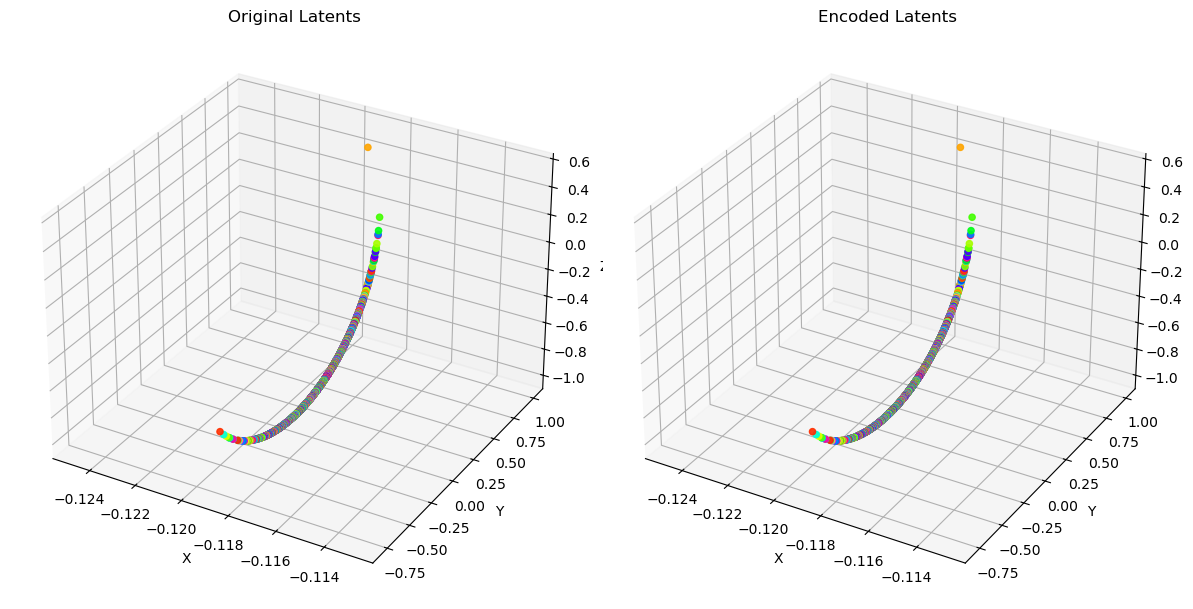

In [5]:
z = sample_uniform_fixed(1).squeeze(0)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch_size) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(batch_size, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

## Training the identity generating process

$g(z) = z$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.6013898849487305 Samples processed: 1 linear disentanglement: 0.502467691898346 permutation disentanglement: -0.0001756747515173629
Loss: 7.600594997406006 Samples processed: 21 linear disentanglement: 0.6558882594108582 permutation disentanglement: 0.005049566272646189
Loss: 7.592617034912109 Samples processed: 41 linear disentanglement: 0.657511293888092 permutation disentanglement: 0.05718483403325081
Loss: 7.5422468185424805 Samples processed: 61 linear disentanglement: 0.6138820648193359 permutation disentanglement: 0.07355942577123642
Loss: 7.490438461303711 Samples processed: 81 linear disentanglement: 0.5884351134300232 permutation disentanglement: 0.1044115200638771
Loss: 7.485822677612305 Samples processed: 101 linear disentanglement: 0.6746127009391785 permutation disentanglement: 0.07910909503698349
Loss: 7.485796928405762 Samples processed: 121 linear disentanglement: 0.6717645525932312 permutation disentangl

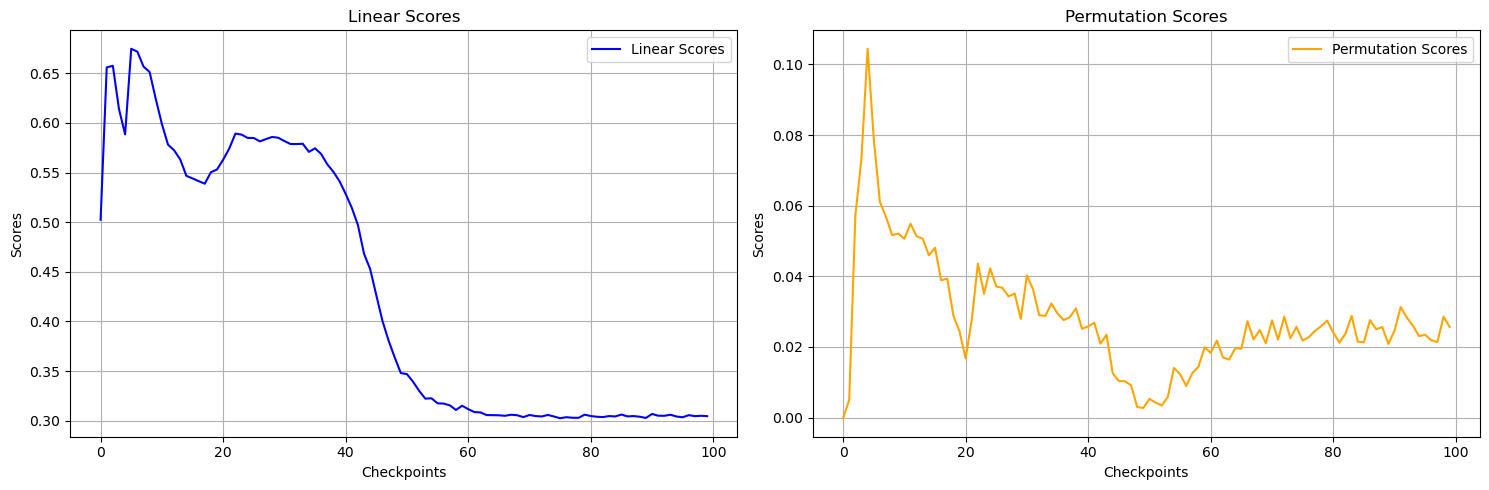

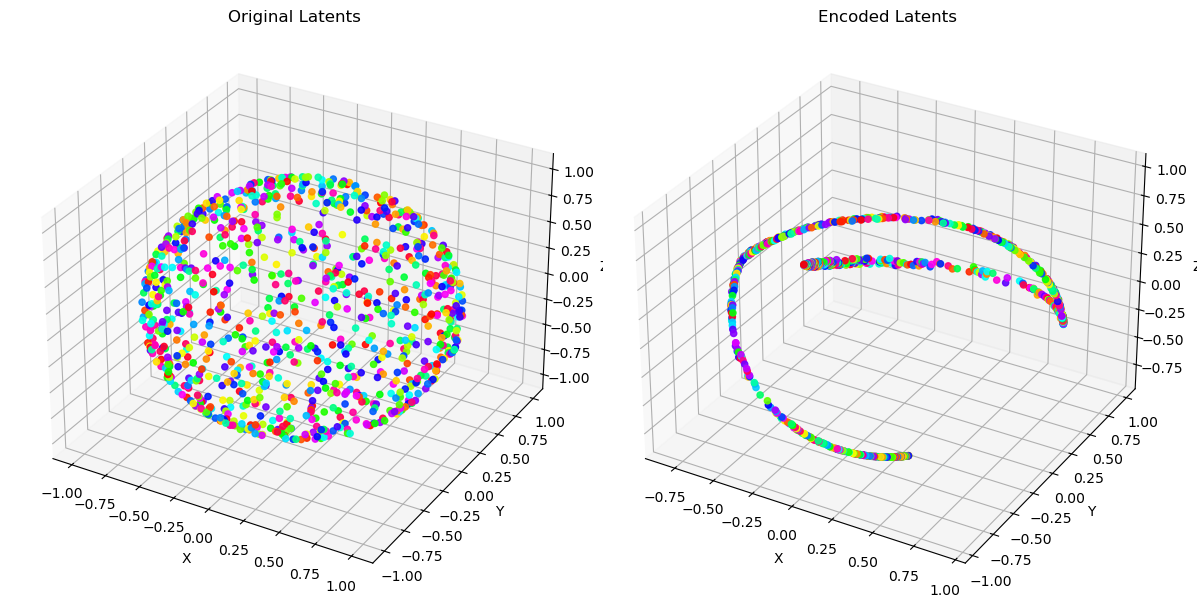

In [8]:
from visualization_utils.scoring import plot_scores

# Initialize the multi-layer perceptron used for encoding
f_constrained = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

g_id = nn.Identity()

simclr_id = SimCLR(
    f_constrained, g_id, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_constrained, scores = simclr_id.train(batch_size, iterations)

plot_scores(plt, scores)

h_constrained = lambda z: f_constrained(g_id(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Linear map generating process

$g(z) = Az$, where $A \in \mathbb{R}^{k \times 3}$ and $k \in \{4,5,6,7\}$ and $rank(A) = 3$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601391792297363 Samples processed: 1 linear disentanglement: 0.3760242164134979 permutation disentanglement: 0.00025628009461797774
Loss: 7.600498199462891 Samples processed: 21 linear disentanglement: 0.3645714223384857 permutation disentanglement: 0.00809727143496275
Loss: 7.5904130935668945 Samples processed: 41 linear disentanglement: 0.35948529839515686 permutation disentanglement: 0.03868876025080681
Loss: 7.542137145996094 Samples processed: 61 linear disentanglement: 0.3546127378940582 permutation disentanglement: 0.1311863511800766
Loss: 7.5074896812438965 Samples processed: 81 linear disentanglement: 0.33309128880500793 permutation disentanglement: 0.23913031816482544
Loss: 7.504508972167969 Samples processed: 101 linear disentanglement: 0.40391385555267334 permutation disentanglement: 0.23905043303966522
Loss: 7.505068302154541 Samples processed: 121 linear disentanglement: 0.4558146893978119 permutation disent

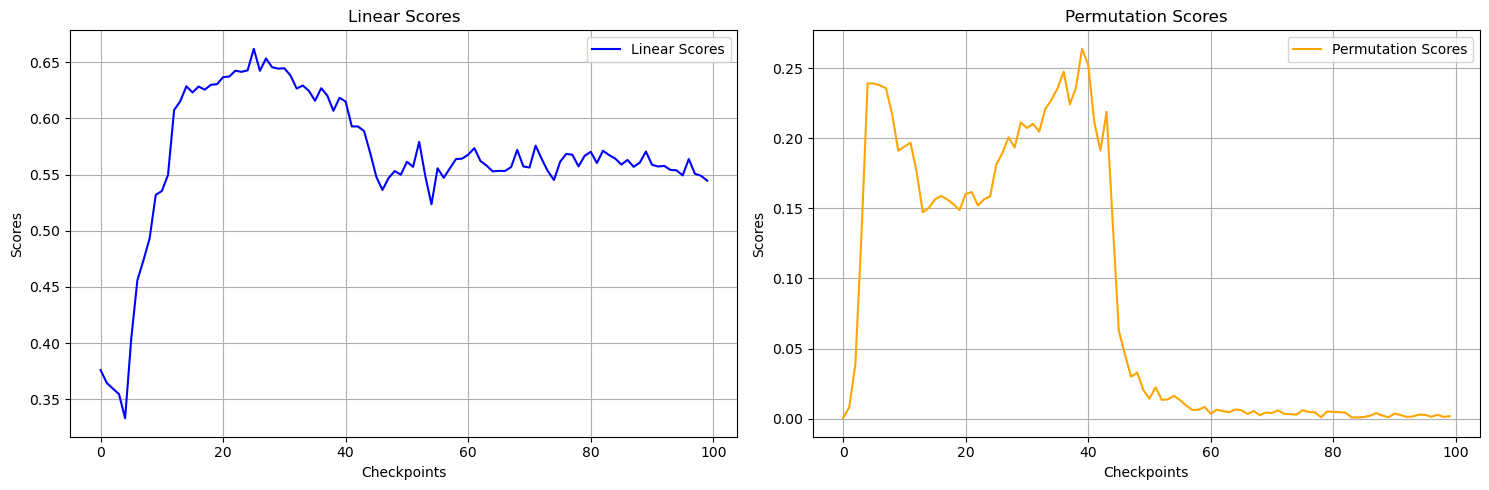

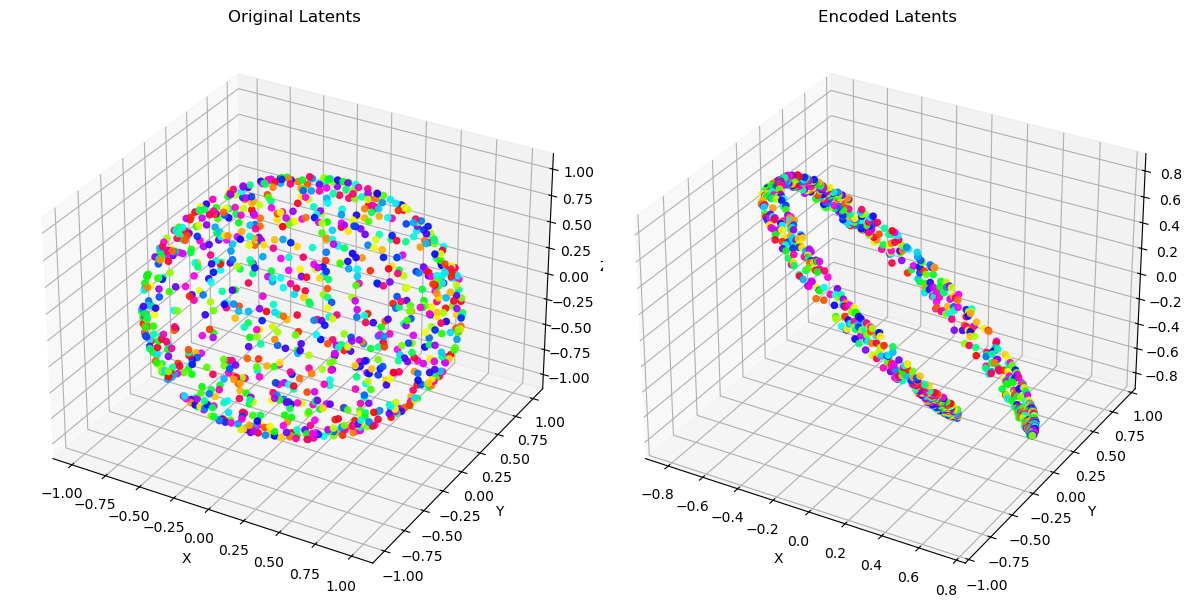

In [10]:
from experiment_utils.linear import perform_linear_experiment

h, scores = perform_linear_experiment(
    4, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.536377906799316 Samples processed: 1 linear disentanglement: 0.6072105169296265 permutation disentanglement: -6.198883056640625e-05
Loss: 8.41539192199707 Samples processed: 251 linear disentanglement: 0.5597296357154846 permutation disentanglement: 0.008406619541347027
Loss: 8.415199279785156 Samples processed: 501 linear disentanglement: 0.3714272975921631 permutation disentanglement: 0.003227929351851344
Loss: 8.414119720458984 Samples processed: 751 linear disentanglement: 0.30157801508903503 permutation disentanglement: 0.027938345447182655
Loss: 8.414151191711426 Samples processed: 1001 linear disentanglement: 0.2995994985103607 permutation disentanglement: 0.025651076808571815
Loss: 8.414170265197754 Samples processed: 1251 linear disentanglement: 0.3023449182510376 permutation disentanglement: 0.025912344455718994
Loss: 8.414085388183594 Samples processed: 1501 linear disentanglement: 0.30069077014923096 permutati

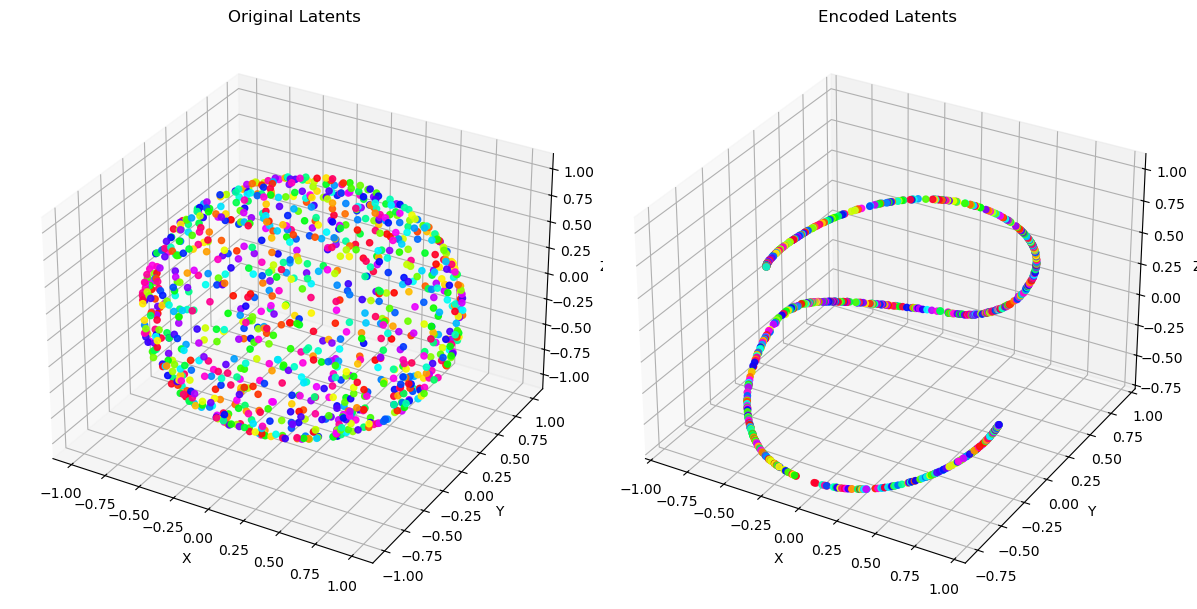

In [ ]:
from experiment_utils.linear import perform_linear_experiment

h, scores = perform_linear_experiment(
    5, iterations * 3, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.536312103271484 Samples processed: 1 linear disentanglement: 0.33544817566871643 permutation disentanglement: 0.0008705258369445801
Loss: 8.415616989135742 Samples processed: 251 linear disentanglement: 0.4837270677089691 permutation disentanglement: 0.268974632024765
Loss: 8.415386199951172 Samples processed: 501 linear disentanglement: 0.3355962336063385 permutation disentanglement: 0.25040826201438904
Loss: 8.414518356323242 Samples processed: 751 linear disentanglement: 0.30810773372650146 permutation disentanglement: 0.24730215966701508
Loss: 8.41429615020752 Samples processed: 1001 linear disentanglement: 0.29796749353408813 permutation disentanglement: 0.2341470718383789
Loss: 8.414107322692871 Samples processed: 1251 linear disentanglement: 0.29650911688804626 permutation disentanglement: 0.2391393780708313
Loss: 8.414079666137695 Samples processed: 1501 linear disentanglement: 0.29576611518859863 permutation dise

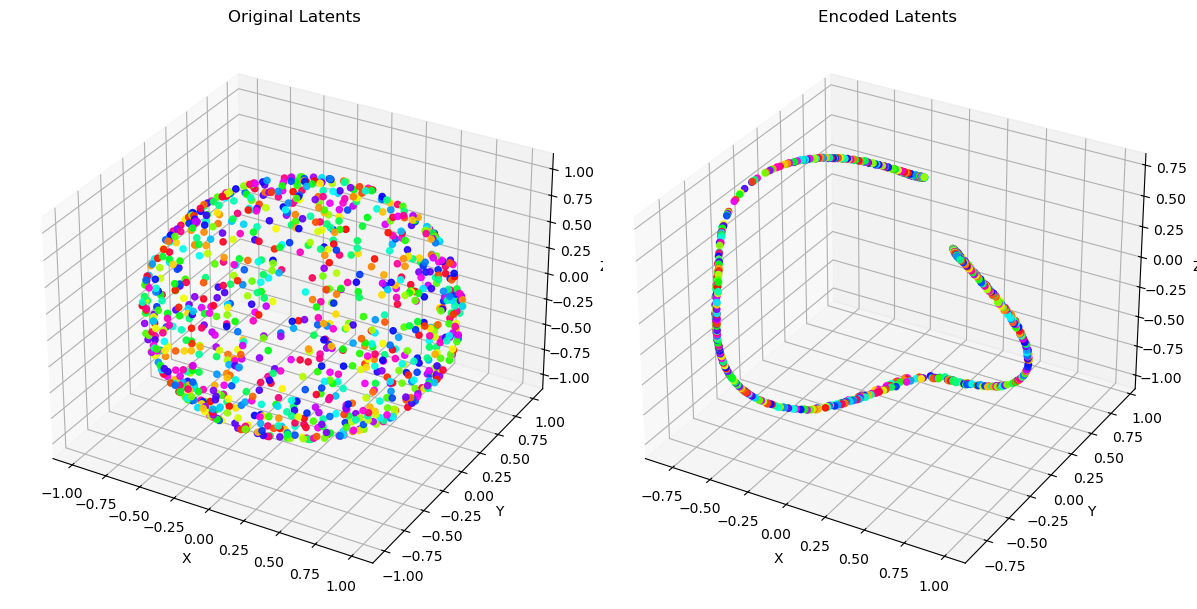

In [ ]:
from experiment_utils.linear import perform_linear_experiment

h, scores = perform_linear_experiment(
    6, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.536331176757812 Samples processed: 1 linear disentanglement: 0.36173930764198303 permutation disentanglement: -1.7662843674770556e-05
Loss: 8.415362358093262 Samples processed: 251 linear disentanglement: 0.5371754765510559 permutation disentanglement: 0.1893915981054306
Loss: 8.414107322692871 Samples processed: 501 linear disentanglement: 0.3037594258785248 permutation disentanglement: 0.12562231719493866
Loss: 8.414128303527832 Samples processed: 751 linear disentanglement: 0.30204007029533386 permutation disentanglement: 0.12068653106689453
Loss: 8.414085388183594 Samples processed: 1001 linear disentanglement: 0.3031691312789917 permutation disentanglement: 0.12147220224142075
Loss: 8.414093017578125 Samples processed: 1251 linear disentanglement: 0.3018759787082672 permutation disentanglement: 0.12735551595687866
Loss: 8.414129257202148 Samples processed: 1501 linear disentanglement: 0.3036104142665863 permutation d

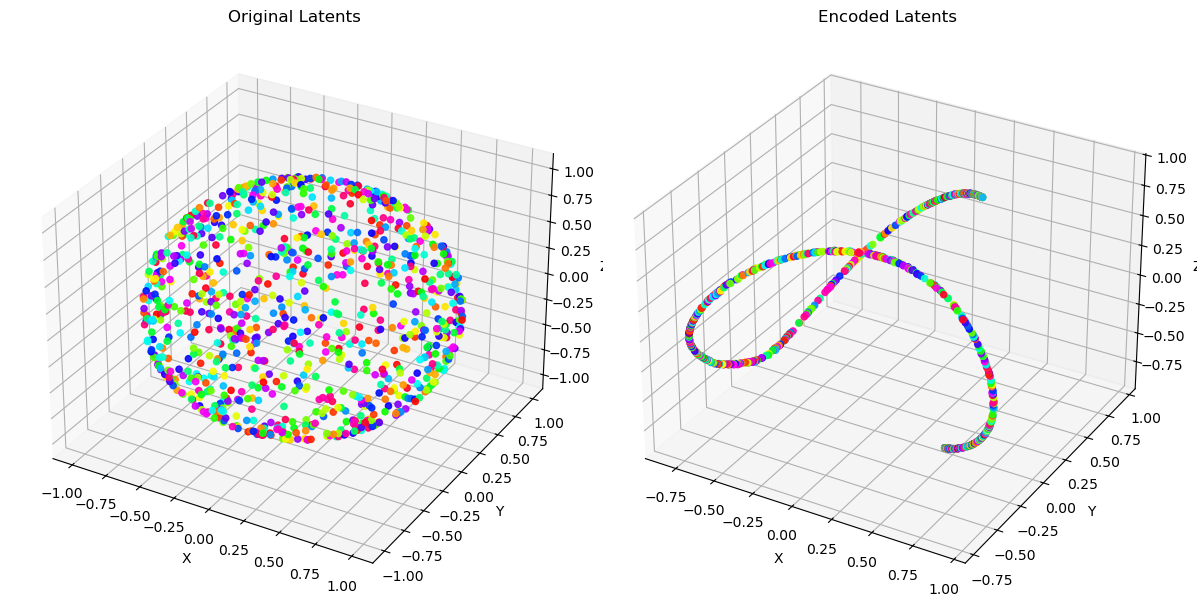

In [ ]:
from experiment_utils.linear import perform_linear_experiment

h, scores = perform_linear_experiment(
    7, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

plot_scores(plt, scores)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Spiral generating process

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601390838623047 Samples processed: 1 linear disentanglement: 0.1604100614786148 permutation disentanglement: -5.328655242919922e-05
Loss: 7.6005940437316895 Samples processed: 21 linear disentanglement: 0.30802345275878906 permutation disentanglement: 0.0012980103492736816
Loss: 7.594261169433594 Samples processed: 41 linear disentanglement: 0.321359246969223 permutation disentanglement: 0.010715167038142681
Loss: 7.561582565307617 Samples processed: 61 linear disentanglement: 0.308980256319046 permutation disentanglement: 0.06741420179605484
Loss: 7.506782531738281 Samples processed: 81 linear disentanglement: 0.2989182770252228 permutation disentanglement: 0.24756313860416412
Loss: 7.50717306137085 Samples processed: 101 linear disentanglement: 0.29260677099227905 permutation disentanglement: 0.23097021877765656
Loss: 7.5032806396484375 Samples processed: 121 linear disentanglement: 0.30165237188339233 permutation disen

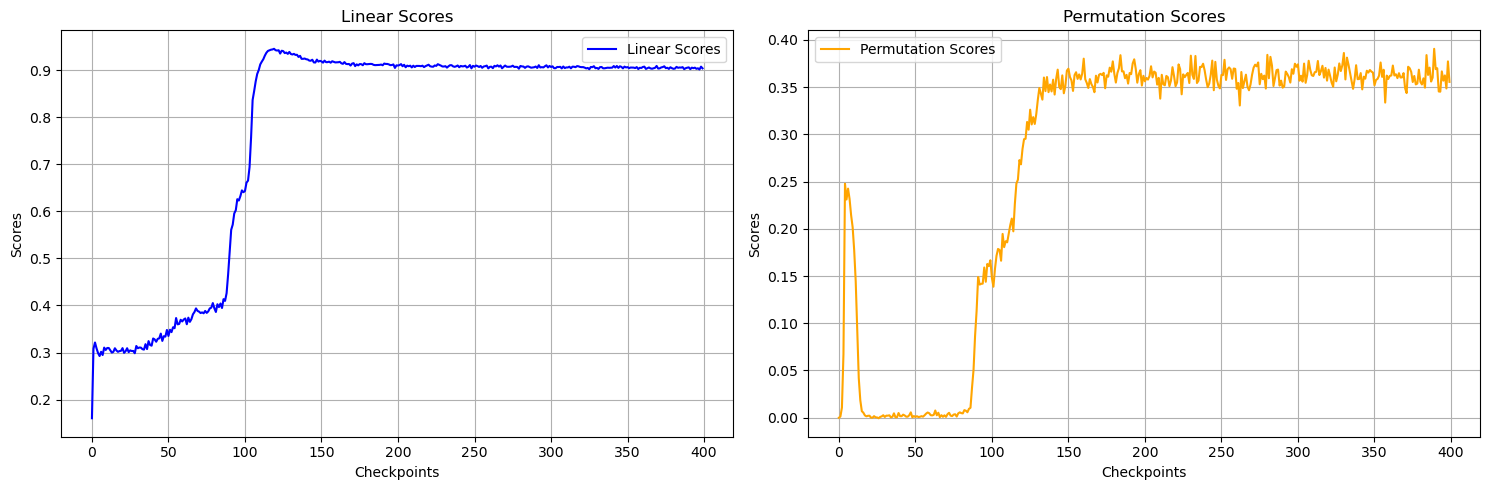

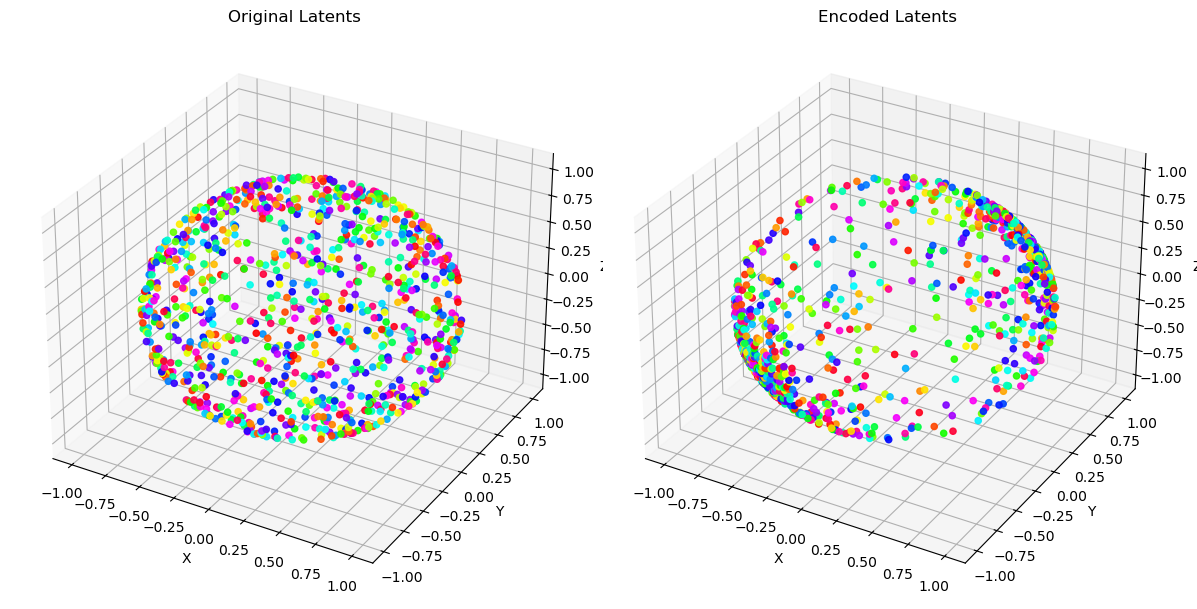

In [ ]:
from data.generation import SpiralRotation

f_spiral = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

g_spiral = SpiralRotation(2)

simclr_spiral = SimCLR(
    f_spiral, g_spiral, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_spiral, scores = simclr_spiral.train(batch_size, iterations)

plot_scores(plt, scores)

h_spiral = lambda z: f_spiral(g_spiral(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_spiral(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Patched generating process

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.60136079788208 Samples processed: 1 linear disentanglement: 0.45187675952911377 permutation disentanglement: 0.0003277460637036711
Loss: 7.600004196166992 Samples processed: 21 linear disentanglement: 0.4400198459625244 permutation disentanglement: 0.006223062518984079
Loss: 7.584136962890625 Samples processed: 41 linear disentanglement: 0.4281562268733978 permutation disentanglement: 0.048411983996629715
Loss: 7.52610969543457 Samples processed: 61 linear disentanglement: 0.3422628939151764 permutation disentanglement: 0.1996515840291977
Loss: 7.50776481628418 Samples processed: 81 linear disentanglement: 0.32318249344825745 permutation disentanglement: 0.2417317032814026
Loss: 7.501677513122559 Samples processed: 101 linear disentanglement: 0.37530577182769775 permutation disentanglement: 0.21597693860530853
Loss: 7.50042724609375 Samples processed: 121 linear disentanglement: 0.4073326289653778 permutation disentanglem

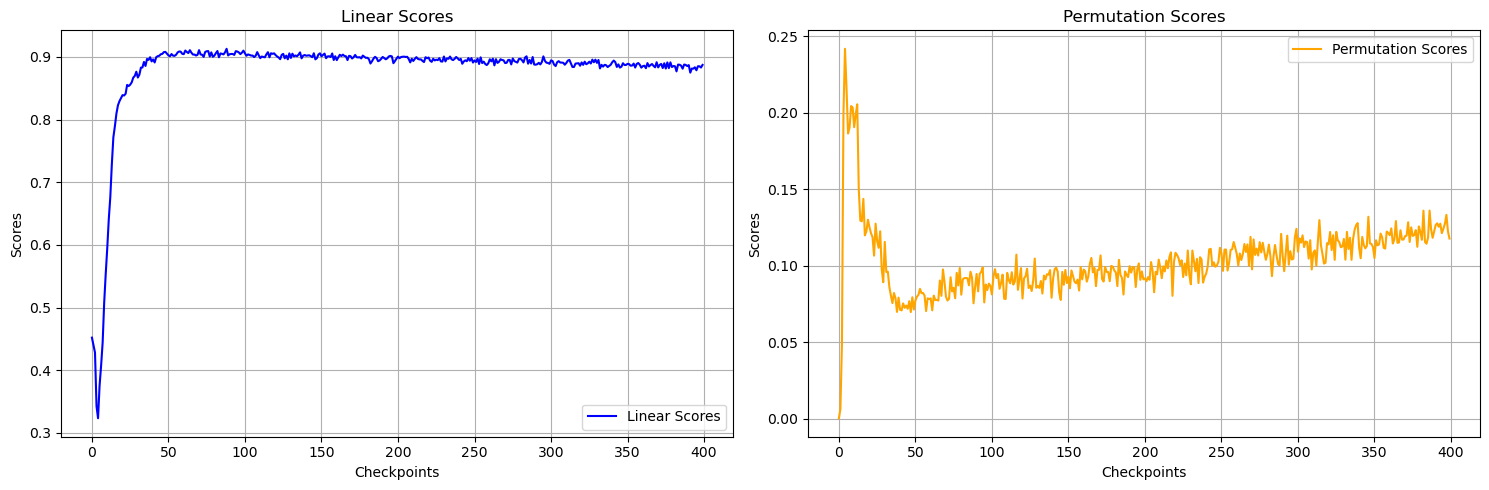

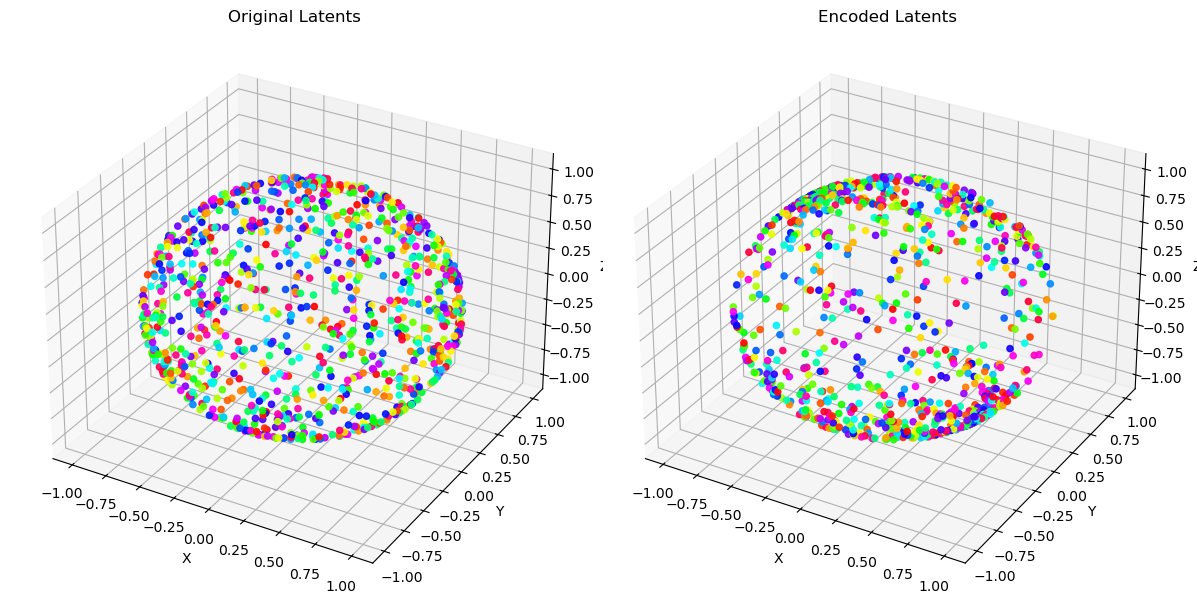

In [ ]:
from data.generation import Patches

g_patches = Patches(5, device)
f_patches = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

simclr_patches = SimCLR(
    f_patches, g_patches, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_patches, scores = simclr_patches.train(batch_size, iterations)

plot_scores(plt, scores)

h_patches = lambda z: f_patches(g_patches(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_patches(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Experiment with the invertible MLP as a data generating process

condition number threshold: 1.039983
layer 1/3,  condition number: 1.0182842121142552
layer 2/3,  condition number: 1.0386268837487342
layer 3/3,  condition number: 1.0358627764043027


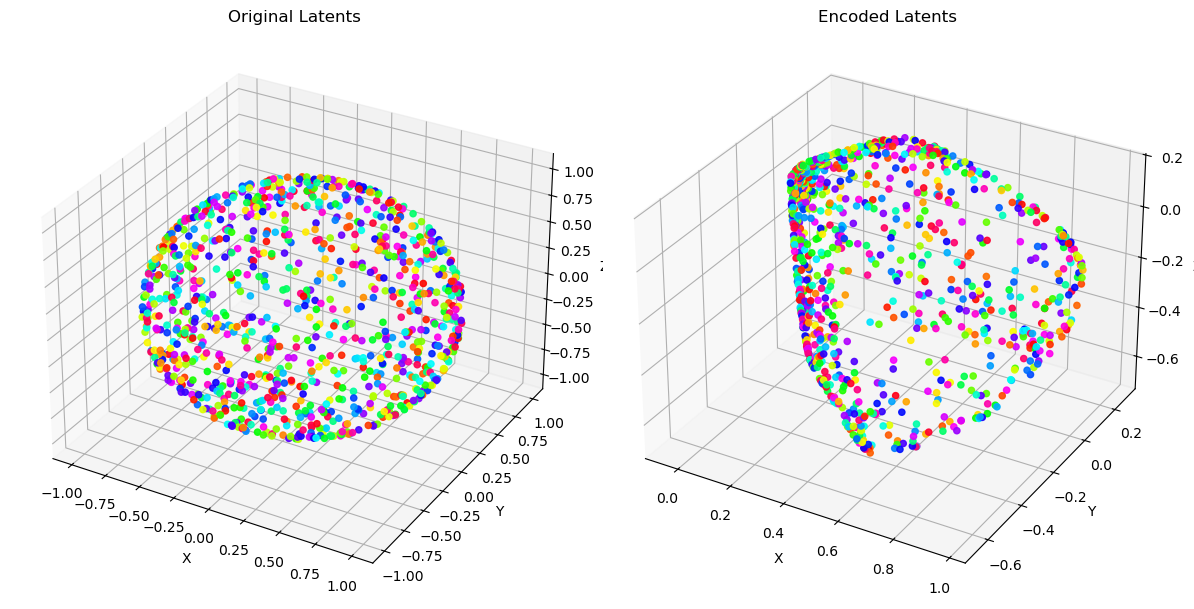

In [20]:
from invertible_network_utils import construct_invertible_mlp

g_mlp = construct_invertible_mlp(
        n=3,
        n_layers=3,
        act_fct='leaky_relu',
        cond_thresh_ratio=0.0,
        n_iter_cond_thresh=25000,
).to(device)

z = full_sphere.uniform(1000).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), g_mlp(z).cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.601395130157471 Samples processed: 1 linear disentanglement: 0.4863341748714447 permutation disentanglement: -1.1185805306013208e-05
Loss: 7.600617408752441 Samples processed: 21 linear disentanglement: 0.6039643883705139 permutation disentanglement: 0.001415292383171618
Loss: 7.591039657592773 Samples processed: 41 linear disentanglement: 0.577239453792572 permutation disentanglement: 0.04396573826670647
Loss: 7.544264793395996 Samples processed: 61 linear disentanglement: 0.4730253219604492 permutation disentanglement: 0.1619335412979126
Loss: 7.50425910949707 Samples processed: 81 linear disentanglement: 0.408063143491745 permutation disentanglement: 0.1492794156074524
Loss: 7.498875617980957 Samples processed: 101 linear disentanglement: 0.4186061918735504 permutation disentanglement: 0.1352265626192093
Loss: 7.49833869934082 Samples processed: 121 linear disentanglement: 0.41424068808555603 permutation disentanglemen

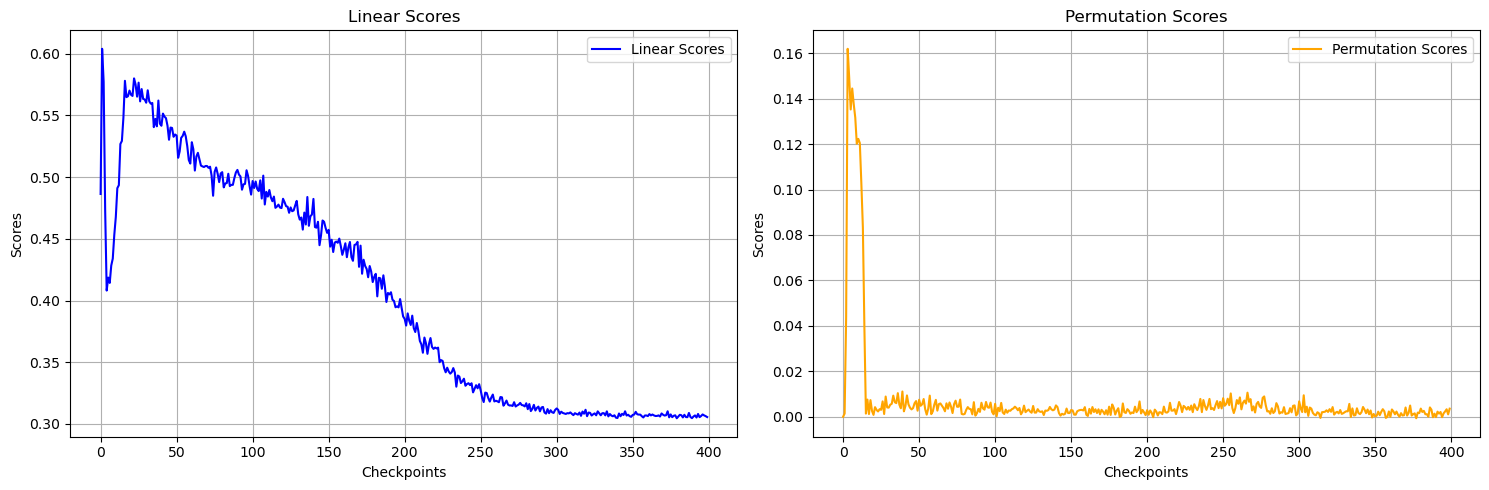

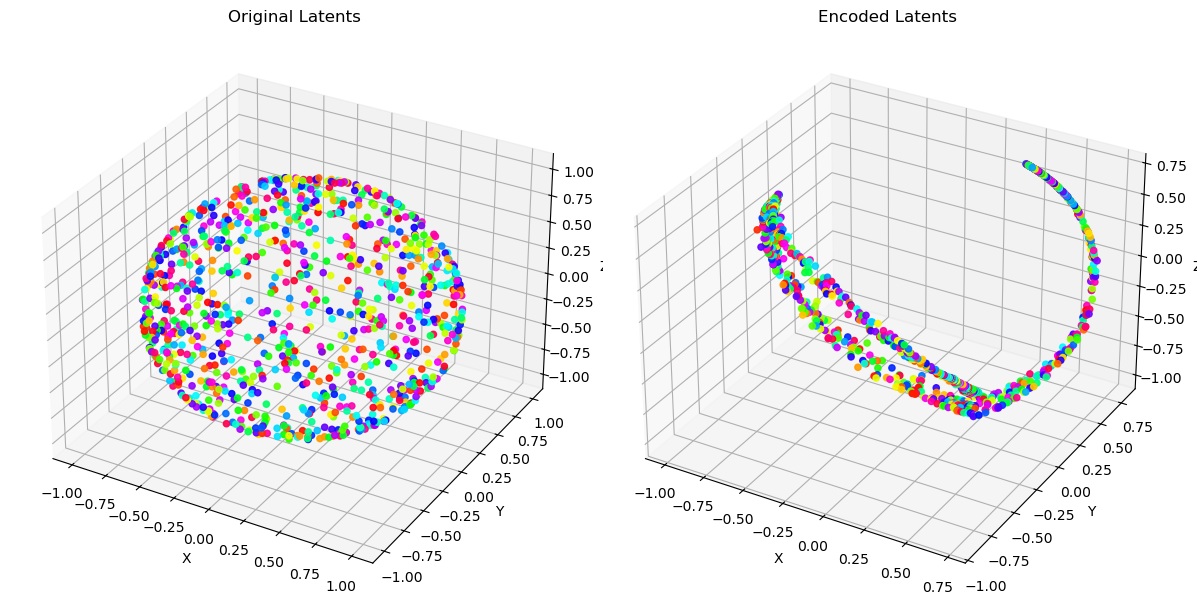

In [31]:
f_mlp = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

simclr_mlp = SimCLR(
    f_mlp, g_mlp, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_mlp, scores = simclr_mlp.train(batch_size, iterations * 4)

plot_scores(plt, scores)

h_mlp = lambda latent: f_mlp(g_mlp(latent))

z = full_sphere.uniform(1000).to(device)
z_enc = h_mlp(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Next

- Run it with a correct model (Cross-Entropy with a correct normalizer)